In [105]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
from torchviz import make_dot

import matplotlib.pyplot as plt
%matplotlib inline
# ^ jupyter notebook magic function

from typing import Any, Dict, List, Tuple, Union
from torch.jit.annotations import TensorType

In [ ]:
# MNIST dataset and dataloaders
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = torchvision.datasets.MNIST(root=os.getcwd(), train=True, transform=transform, download=True)

In [ ]:
# Split the dataset into train, val, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=os.cpu_count())
val_loader = DataLoader(val_dataset, batch_size=64, num_workers=os.cpu_count())
test_loader = DataLoader(test_dataset, batch_size=64, num_workers=os.cpu_count())

In [ ]:
# Parameter dictionary for each model and 
# corresponding layer parameters.
params: Dict[str,Dict[str,torch.nn]] = {
    "model.1": {
        "conv_layers": (nn.Conv2d(1, 32, kernel_size=3, padding=1),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2, stride=2),
                        nn.Conv2d(32, 64, kernel_size=3, padding=1),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2, stride=2),
                        nn.Conv2d(64, 128, kernel_size=3, padding=1),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2, stride=2),
                        nn.Conv2d(128, 256, kernel_size=3, padding=1),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2, stride=2),
                        ),
        "fc_layer": (nn.Linear(256, 128),
                     nn.ReLU(),
                     nn.Linear(128, 10),)
    },
    "model.2": {
        "conv_layers": (nn.Conv2d(1, 32, kernel_size=3, padding=1),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2, stride=2),
                        nn.Conv2d(32, 32, kernel_size=3, padding=1),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2, stride=2),
                        nn.Conv2d(32, 32, kernel_size=3, padding=1),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2, stride=2),
                        nn.Conv2d(32, 32, kernel_size=3, padding=1),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2, stride=2)
                        ),
        "fc_layer": (nn.Linear(32, 10),)
    },
    "model.3": {
        "conv_layers": (nn.Conv2d(1, 32, kernel_size=3, padding=1),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2, stride=2),
                        nn.Conv2d(32, 32, kernel_size=3, padding=1),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2, stride=2),
                        nn.Conv2d(32, 32, kernel_size=3, padding=1),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2, stride=2),
                        ),
        "fc_layer": (nn.Linear(32 * 3 * 3, 10),)
    },
    "model.4": {
        "conv_layers": (nn.Conv2d(1, 32, kernel_size=3, padding=1),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2, stride=2),
                        nn.Conv2d(32, 32, kernel_size=3, padding=1),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2, stride=2),
                        ),
        "fc_layer": (nn.Linear(32 * 7 * 7, 10),)
    },
    "model.5": {
        "conv_layers": (nn.Conv2d(1, 32, kernel_size=3, padding=1),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2, stride=2),
                        ),
        "fc_layer": (nn.Linear(14 * 14 * 32, 10))
    },
}

In [ ]:
def count_trainable_parameters(model: pl.LightningModule) -> int:
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params

In [ ]:
def _save_and_viz_pl_model(model: Union[nn.Module,pl.LightningModule], filename: str) -> None:
    """Helper function to visualize and plot the model architecture.

    Args:
        model: Input pytorch (lightning) model.
        filename: Output filename (no file extension).
    """
    # Create a dummy input with the same shape as expected input during training
    dummy_input = torch.randn(1, 1, 28, 28)

    # Generate the visualization of the model architecture
    dot = make_dot(model(dummy_input))
    # params = dict(model.named_parameters())

    # Save the visualization as an image
    dot.format = 'png'
    dot.render(filename, cleanup=True)
    
    return None

In [ ]:
def save_pt_model(model: Union[nn.Module,pl.LightningModule], filename: str) -> None:
    """Saves pytorch (lightning) model, and creates visualization of model architecture.

    Args:
        model: Input pytorch (lightning) model.
        filename: Output filename.
    """
    # TODO: Save metadata file for the model.
    # Check filename
    filename: str
    ext: str
    
    if ('pt' or 'pth') in filename:
        filename, ext = os.path.splitext(filename)
    else:
        ext: str = ".pt"
    
    # Save model (and model state)
    torch.save(model.state_dict(), f"{filename}{ext}")

    # Save image of model architecture
    _save_and_viz_pl_model(model=model, filename=filename)

    return None

In [ ]:
def load_pt_model(model: Union[nn.Module,pl.LightningModule], filename: str) -> Union[nn.Module,pl.LightningModule]:
    """Loads saved/trained model, in which the model class **must** be provided.

    Args:
        model: Input model class objoect.
        filename: Input filename that corresponds to trained saved/trained model.

    Returns:
        Trained model.
    """
    if ('pt' or 'pth') in filename:
        pass
    else:
        filename: str = f"{filename}.pt"

    # model = TheModelClass(*args, **kwargs)
    model.load_state_dict(torch.load(filename))
    model.eval() # sets dropout and batch normalization layers to evaluation mode
    return model

In [215]:
def get_gradient_norms(model: Union[nn.Module,pl.LightningModule], weight: bool = True, bias: bool = False) -> List[Tuple[str,float]]:
    model.eval()
    sample_input = torch.randn(1, 1, 28, 28)  # Replace with your own sample input
    outputs = model(sample_input)
    loss = torch.sum(outputs)  # Create a dummy loss

    # Backpropagate to compute gradients
    loss.backward()

    # Compute gradient norms
    gradient_norms: List[Tuple[str,float]] = []
    for name, param in model.named_parameters():
        if param.grad is not None:
            if weight and ('weight' in name):
                gradient_norms.append((name, param.grad.norm().item()))
            
            if bias and ('bias' in name):
                gradient_norms.append((name, param.grad.norm().item()))
                
    return gradient_norms

In [216]:
def get_layerwise_norms(model: Union[nn.Module,pl.LightningModule], weight: bool = True, bias: bool = False) -> List[Tuple[str,float]]:
    model.eval()
    sample_input = torch.randn(1, 1, 28, 28)  # Replace with your own sample input
    outputs = model(sample_input)
    loss = torch.sum(outputs)  # Create a dummy loss

    # Backpropagate to compute gradients
    loss.backward()
    
    layerwise_norms: List[Tuple[str,float]] = []
    for name, param in model.named_parameters():
        layer_name = name #.split('.')[0]  # Extract the layer name
        norm = param.norm().item()

        if weight and ('weight' in name):
            layerwise_norms.append((layer_name, norm))
        
        if bias and ('bias' in name):
            layerwise_norms.append((layer_name, norm))
            
    return layerwise_norms

In [222]:
def calculate_total_parameter_norm(model):
    total_norm = 0.0
    for param in model.parameters():
        total_norm += param.norm().item()
    return total_norm

In [223]:
def calculate_parameter_norms_per_layer(model, weight: bool = True, bias: bool = False):
    norms_per_layer = {}
    for name, param in model.named_parameters():
        layer_name = name #.split('.')[0]  # Extract the layer name
        norm = param.norm().item()

        if weight and ('weight' in name):
            if layer_name not in norms_per_layer:
                norms_per_layer[layer_name] = []
            norms_per_layer[layer_name].append(norm)
        
        if bias and ('bias' in name):
            if layer_name not in norms_per_layer:
                norms_per_layer[layer_name] = []
            norms_per_layer[layer_name].append(norm)
    return norms_per_layer

In [225]:
calculate_total_parameter_norm(model=model)

46.5637232363224

Parameter containing:
tensor([[[[ 0.0107, -0.4344, -0.4431],
          [ 0.3092,  0.9077,  0.6962],
          [-0.2895, -0.5783, -0.2747]]],


        [[[-0.4840,  0.1207,  0.4232],
          [ 0.1232, -0.4691, -0.0978],
          [-0.0014,  0.3906, -0.3247]]],


        [[[-0.5230,  0.5614,  0.1648],
          [-0.6405,  0.7871, -0.2964],
          [-0.4766,  0.6181, -0.1111]]],


        [[[ 0.2155,  0.4697,  0.5529],
          [-0.6010, -0.3685, -0.4876],
          [-0.0944, -0.2210,  0.0234]]],


        [[[-0.4442, -0.6376,  0.6735],
          [-0.5989,  0.7884,  0.2650],
          [ 0.8036,  0.4333, -0.5040]]],


        [[[-0.0866, -0.4306,  0.2079],
          [-0.4045,  0.4508,  0.2470],
          [ 0.4847, -0.2742, -0.3739]]],


        [[[ 0.4748,  0.4071, -0.4229],
          [ 0.2941, -0.0417, -0.7052],
          [ 0.6949, -0.3703,  0.1034]]],


        [[[ 0.1480,  0.4315, -0.4692],
          [-0.1880,  0.4988,  0.3659],
          [-0.5237, -0.2290,  0.0537]]],


        [[

In [ ]:
# Define the LightningModule
class ConvNet(pl.LightningModule):
    def __init__(self, params: Dict[str,torch.nn]):
        super(ConvNet, self).__init__()
        self.save_hyperparameters()
        self.conv_layers = nn.Sequential(
            *params.get('conv_layers')
        )
        
        try:
            self.fc_layer = nn.Sequential(
                *params.get('fc_layer')
            )
        except TypeError:
            self.fc_layer = nn.Sequential(
                params.get('fc_layer')
            )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001)
    
    # Define the training step method
    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = nn.CrossEntropyLoss()(outputs, targets)
        self.log('train_loss', loss)
        return loss
    
    # Define the validation step method
    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = nn.CrossEntropyLoss()(outputs, targets)
        self.log('val_loss', loss, prog_bar=True)  # Logging the validation loss
    
    # Define the test step method
    def test_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = nn.CrossEntropyLoss()(outputs, targets)
        self.log('test_loss', loss)  # Logging the test loss
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == targets).float().mean()
        self.log('test_acc', acc, prog_bar=True)  # Logging the test accuracy

In [ ]:
params.keys()

In [ ]:
# Create trainer object
trainer = pl.Trainer(accelerator='mps',max_epochs=10,devices=1)  # Set max_epochs and gpus according to your environment

In [ ]:
for param in params.keys():
    # Print Model number to screen
    print(f"\n{param}:\n")
    
    # Initialize the Lightning Trainer
    model = ConvNet(params=params.get(param))
    # trainer = pl.Trainer(accelerator='mps',max_epochs=10,devices=1)  # Set max_epochs and gpus according to your environment

    # Train the model using PyTorch Lightning
    trainer.fit(model, train_loader, val_loader)

    # Save trained model
    save_pt_model(model=model,filename=f"models/{param}")

In [194]:
results_dict: Dict[str,Dict[str,Any]] = {}

In [217]:
for param in params.keys():
    # Print Model number to screen
    print(f"\n{param}:\n")

    tmp_dict = {}

    # Load model
    model = load_pt_model(model=ConvNet(params=params.get(param)),filename=f"models/{param}")
    # trainer = pl.Trainer(accelerator='mps',max_epochs=10,devices=1)  # Set max_epochs and gpus according to your environment

    # Evaluate the model on the test data
    print(f"Training accuracy:")
    train_results = trainer.test(model, dataloaders=train_loader)

    # Evaluate the model on the test data
    print(f"Testing accuracy:")
    test_results = trainer.test(model, dataloaders=test_loader)

    # Countable parameters
    print(f"Number of trainable parameters (weights): {count_trainable_parameters(model=model):,}")
    countable_parameters: str = f"{count_trainable_parameters(model=model):,}"

    # Gradient Norms
    grad_norms = get_gradient_norms(model=model, weight=True)

    # Layerwise Norms
    layer_norms = get_layerwise_norms(model=model, weight=True)

    tmp_dict = {
        "train_acc": f"{train_results[0].get('test_acc'):.4f}",
        "test_acc": f"{test_results[0].get('test_acc'):.4f}",
        "parameters": countable_parameters,
        "grad_norm": grad_norms,
        "layer_norm": layer_norms,
    }

    results_dict.update({param:tmp_dict})


model.1:

Training accuracy:


/Users/adebayobraimah/Desktop/projects/fall2023project/.env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:480: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.995270848274231     │
│         test_loss         │    0.01704791933298111    │
└───────────────────────────┴───────────────────────────┘

Testing accuracy:


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9863333106040955     │
│         test_loss         │    0.08278840780258179    │
└───────────────────────────┴───────────────────────────┘

Number of trainable parameters (weights): 422,026

model.2:

Training accuracy:


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9964583516120911     │
│         test_loss         │    0.01097323838621378    │
└───────────────────────────┴───────────────────────────┘

Testing accuracy:


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9869999885559082     │
│         test_loss         │    0.0553138442337513     │
└───────────────────────────┴───────────────────────────┘

Number of trainable parameters (weights): 28,394

model.3:

Training accuracy:


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9959375262260437     │
│         test_loss         │   0.011619341559708118    │
└───────────────────────────┴───────────────────────────┘

Testing accuracy:


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9833333492279053     │
│         test_loss         │    0.0808323547244072     │
└───────────────────────────┴───────────────────────────┘

Number of trainable parameters (weights): 21,706

model.4:

Training accuracy:


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9977708458900452     │
│         test_loss         │   0.006235057022422552    │
└───────────────────────────┴───────────────────────────┘

Testing accuracy:


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9851666688919067     │
│         test_loss         │    0.08124293386936188    │
└───────────────────────────┴───────────────────────────┘

Number of trainable parameters (weights): 25,258

model.5:

Training accuracy:


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9970208406448364     │
│         test_loss         │   0.008239409886300564    │
└───────────────────────────┴───────────────────────────┘

Testing accuracy:


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9776666760444641     │
│         test_loss         │    0.10316558182239532    │
└───────────────────────────┴───────────────────────────┘

Number of trainable parameters (weights): 63,050


In [191]:
results = trainer.test(model, dataloaders=train_loader)

/Users/adebayobraimah/Desktop/projects/fall2023project/.env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:480: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9970208406448364     │
│         test_loss         │    0.00823940895497799    │
└───────────────────────────┴───────────────────────────┘

In [218]:
results_dict

{'model.1': {'train_acc': '0.9953',
  'test_acc': '0.9863',
  'parameters': '422,026',
  'grad_norm': [('conv_layers.0.weight', 42.79999542236328),
   ('conv_layers.3.weight', 66.82827758789062),
   ('conv_layers.6.weight', 79.48753356933594),
   ('conv_layers.9.weight', 101.20499420166016),
   ('fc_layer.0.weight', 56.832176208496094),
   ('fc_layer.2.weight', 33.2569694519043)],
  'layer_norm': [('conv_layers.0.weight', 3.758045196533203),
   ('conv_layers.3.weight', 16.317190170288086),
   ('conv_layers.6.weight', 28.013669967651367),
   ('conv_layers.9.weight', 38.37032699584961),
   ('fc_layer.0.weight', 13.226685523986816),
   ('fc_layer.2.weight', 4.223467826843262)]},
 'model.2': {'train_acc': '0.9965',
  'test_acc': '0.9870',
  'parameters': '28,394',
  'grad_norm': [('conv_layers.0.weight', 52.87578201293945),
   ('conv_layers.3.weight', 81.1396484375),
   ('conv_layers.6.weight', 123.01580810546875),
   ('conv_layers.9.weight', 209.22975158691406),
   ('fc_layer.0.weight', 2

In [214]:
# results[0].get("test_acc").4f
f"{results[0].get('test_acc'):.4f}"

'0.9970'

In [77]:
model

ConvNet(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=6272, out_features=10, bias=True)
  )
)

In [84]:
model.eval()

ConvNet(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=6272, out_features=10, bias=True)
  )
)

In [85]:
sample_input = torch.randn(1, 1, 28, 28)  # Replace with your own sample input
outputs = model(sample_input)
loss = torch.sum(outputs)  # Create a dummy loss

# Backpropagate to compute gradients
loss.backward()

In [87]:
for name,param in model.named_parameters():
    print(name, param.grad.norm().item())

conv_layers.0.weight 403.0003967285156
conv_layers.0.bias 340.44183349609375
fc_layer.0.weight 305.35125732421875
fc_layer.0.bias 3.1622776985168457


In [201]:
def get_gradient_norms(model: Union[nn.Module,pl.LightningModule], weight: bool = True, bias: bool = False) -> List[Tuple[str,float]]:
    model.eval()
    sample_input = torch.randn(1, 1, 28, 28)  # Replace with your own sample input
    outputs = model(sample_input)
    loss = torch.sum(outputs)  # Create a dummy loss

    # Backpropagate to compute gradients
    loss.backward()

    # Compute gradient norms
    gradient_norms: List[Tuple[str,float]] = []
    for name, param in model.named_parameters():
        if param.grad is not None:
            if weight and ('weight' in name):
                gradient_norms.append((name, param.grad.norm().item()))
            
            if bias and ('bias' in name):
                gradient_norms.append((name, param.grad.norm().item()))
                
    return gradient_norms

In [202]:
def get_layerwise_norms(model: Union[nn.Module,pl.LightningModule], weight: bool = True, bias: bool = False) -> List[Tuple[str,float]]:
    model.eval()
    sample_input = torch.randn(1, 1, 28, 28)  # Replace with your own sample input
    outputs = model(sample_input)
    loss = torch.sum(outputs)  # Create a dummy loss

    # Backpropagate to compute gradients
    loss.backward()
    
    layerwise_norms: List[Tuple[str,float]] = []
    for name, param in model.named_parameters():
        layer_name = name #.split('.')[0]  # Extract the layer name
        norm = param.norm().item()

        if weight and ('weight' in name):
            layerwise_norms.append((layer_name, norm))
        
        if bias and ('bias' in name):
            layerwise_norms.append((layer_name, norm))
            
    return layerwise_norms

In [93]:
get_layerwise_norms(model=model)

[('conv_layers.0.weight', 6.930140018463135),
 ('conv_layers.0.bias', 2.115267038345337),
 ('fc_layer.0.weight', 37.295448303222656),
 ('fc_layer.0.bias', 0.22286787629127502)]

In [94]:
get_gradient_norms(model=model)

[('conv_layers.0.weight', 403.0003967285156),
 ('conv_layers.0.bias', 340.44183349609375),
 ('fc_layer.0.weight', 305.35125732421875),
 ('fc_layer.0.bias', 3.1622776985168457)]

In [165]:
image, label = train_dataset[0]

In [166]:
label

2

In [170]:
type(image.reshape(28,28))

torch.Tensor

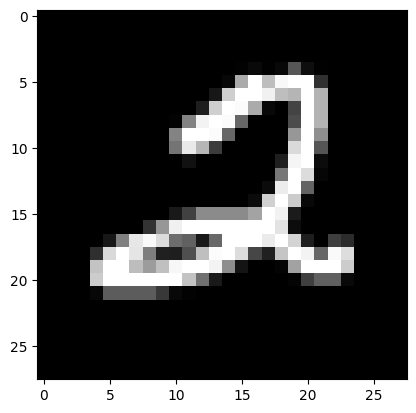

In [167]:
plt.imshow(image.reshape(28,28), cmap='gray')

In [117]:
model

ConvNet(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=6272, out_features=10, bias=True)
  )
)

In [121]:
from torchray.attribution.grad_cam import grad_cam
from PIL import Image

In [175]:
def compute_gradcam(model, input_image, target_class):
    # Set the model to evaluation mode
    model.eval()

    # Convert the input image to a PIL Image if it's a numpy array
    if isinstance(input_image, np.ndarray):
        input_image = Image.fromarray(input_image)
    elif isinstance(input_image, torch.Tensor):
        input_image = (torch.as_tensor(input_image.reshape(28,28)).numpy())
        input_image = Image.fromarray((input_image * 255).astype(np.uint8))

    # Apply preprocessing transformations to the input image
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    input_tensor = transform(input_image).unsqueeze(0)  # Add batch dimension

    # Compute GradCAM
    cam = grad_cam(model, input_tensor, target_class)

    # Normalize the GradCAM heatmap
    cam_normalized = (cam - cam.min()) / (cam.max() - cam.min())

    return cam_normalized

In [168]:
type(label)

int

In [169]:
type(image)

torch.Tensor

In [129]:
image

tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1

In [131]:
image.numpy().shape

(1, 28, 28)

In [126]:
isinstance(image,torch.Tensor)

True

In [174]:
cam = compute_gradcam(model, image, label)

TypeError: grad_cam() missing 1 required keyword-only argument: 'saliency_layer'

In [180]:
input_image = image

In [182]:
input_image = (torch.as_tensor(input_image.reshape(28,28)).numpy())
input_image = Image.fromarray((input_image * 255).astype(np.uint8))

In [183]:
input_image

In [185]:
from IPython.display import Markdown as md

In [186]:
f = 55

In [188]:
md(f"f is {f}")

f is 55

In [203]:
MARKDOWN = f"""

| model \ specifications | Train Accuracy | Test Accuracy | Number of Parameters | Gradient Norm | Layerwise Norm | Total Parameter Norm | Per Layer Parameter Norm |
|------------------------|----------------|---------------|----------------------|---------------|----------------|----------------------|--------------------------|
| 1                      |                |               |                      |               |                |                      |                          |
| 2                      |                |               |                      |               |                |                      |                          |
| 3                      |                |               |                      |               |                |                      |                          |
| 4                      |                |               |                      |               |                |                      |                          |
| 5                      |                |               |                      |               |                |                      |                          |
"""

In [204]:
md(MARKDOWN)



| model \ specifications | Train accuracy | Test accuracy | Number of parameters | Gradient Norm | Layerwise Norm |
|------------------------|----------------|---------------|----------------------|---------------|----------------|
| 1                      | [('conv_layers.0.weight', 6.930140018463135), ('fc_layer.0.weight', 37.295448303222656)]               |               |                      |               |                |
| 2                      |                |               |                      |               |                |
| 3                      |                |               |                      |               |                |
| 4                      |                |               |                      |               |                |
| 5                      |                |               |                      |               |                |
